In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime

## Rosbank ML Competition

Ссылка на соревнование: https://boosters.pro/champ_15

Росбанк – часть ведущей международной финансовой группы Societe Generale, банк включен ЦБ РФ в число 11 системно значимых кредитных организаций России. Инновации неотъемлемый процесс работы Росбанка, поэтому активно развивается направленный анализа больших данных.

- Данные

Датасет, который содержит историю транзакций клиентов за 3 месяца льготного использования банковского продукта

- Задача

Задача бинарной классификации – прогноз оттока клиентов

Колонка cl_id содержит вутренний id клиента. Для каждого уникальнго cl_id следует предсказать продолжит ли клиент пользоваться продуктом (target_flag). Значение 0 соответствует отказу, а значение 1 соответствует продолжению использования

In [3]:
raw_df = pd.read_csv('../input/rosbank_train.csv')
raw_df.head(5)
# target_sum - можно выкинуть, переменная участвует в другой задаче

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 10 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_flag     490513 non-null int64
target_sum      490513 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 37.4+ MB


In [5]:
print("Total clients: ", len(raw_df.cl_id.unique()))

Total clients:  5000


Всего 5000 клиентов, случайным образом возьмем 1000 клиентов для тестирования

In [6]:
cl_ids_test = np.random.choice(raw_df.cl_id.unique(), size=1000, replace=False)
cl_ids_test_set = set(cl_ids_test)
len(cl_ids_test_set)

1000

In [7]:
# create transactions dataset for train
transactions_train = raw_df[~raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in train dataset: ", len(transactions_train))
# create transactions dataset for test
transactions_test = raw_df[raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in test dataset: ", len(transactions_test))

Total transactions in train dataset:  389292
Total transactions in test dataset:  101221


## Домашняя работа

1. Наборы данных вида Transactions (несколько транзакций на одного клиента) трансформировать в таблицу, где cl_id будут уникальными (соответственно 4000 строк в train и 1000 строк в test
2. Для каждого cl_id будет уникальное целевое событие target_flag, а также уникальный канал привлечения клиента channel_type (клиент привлекается лишь однажды и с самого начала его записи присваивается значение канала привлечения)
3. При агрегации (*pandas.DataFrame.groupby*) по cl_id (или по связке cl_id, channel_type, target_flag) необходимо создавать производные фичи, идеи для таких фичей могут быть следующими:

    - общая сумма транзакций по каждой из trx_category
    - общая сумма транзакции по основным вылютам (напр. выделить рубли, доллары и евро - предположительно, это будут самые крупные категории)
    - общая сумма транзакций по категориям MCC кодов (например, выбрать основные/популярные MCC коды). ВНИМАНИ! Некоторые MCC коды из train могут быть не представлены в test. Про MCC коды в целом: http://www.banki.ru/wikibank/mcc-kod/; Справочник MCC кодов: https://mcc-codes.ru/code; Про некоторые категории кэшбека Росбанка: https://mcc-codes.ru/card/rosbank-sverkh-plus;
    - возможные агрегации по времени суток и дням недели - траты в выходные (праздники) или будни, в ночное время или в рабочее и т.д.
4. **Обязательная часть**: провести первичный анализ данных - посмотреть распределения признаков, выделить самые популярные MCC, помотреть активность клиентов по дням недели/времени, какие категории транзакции (trx_category) наиболее популярны и т.д. Получить инсайты, которые в дальнейшем помогут вам правильно подготовить фичи
5. **Дополнительная часть**: с отобранными фичами и полученными компонентами обучить модель (тип алгоритма на свой вкус, можно начать с линейной) и померить качество на локальном тестовом наборе данных (локальная валидация), который создается в этом ноутбуке. **Метрика оценки качества - ROC AUC**(https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
6. Задания принимаются в виде ноутбука с кодов/картинками выполненной обязательной части + указанием места в leaderboard при решении дополнительной

При возникновении вопросов и для отправки домашнего задания - egsachko@gmail.com или http://fb.com/sachkoe
    

In [8]:
transactions_train.channel_type.value_counts(dropna=False)

type1    237675
type2    138470
type5      4958
type4      3089
type3      2726
NaN        2374
Name: channel_type, dtype: int64

In [9]:
raw_df_grouped = raw_df[
    ['cl_id', 'amount', 'MCC']
].groupby(['cl_id', 'MCC']).agg(['sum', 'count'])

# aggregated_dataset = raw_df_grouped.unstack().fillna(0)
aggregated_dataset = raw_df_grouped.unstack()

In [10]:
def transaction_by_day_count(dataset):
    dataset['day_of_transaction'] = dataset['TRDATETIME'].apply( lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%w') ) 
    tmp_df = dataset.groupby(['cl_id','day_of_transaction'])['day_of_transaction'].size().unstack().fillna(0).reset_index()
    old_columns = [old_col for old_col in tmp_df.columns.tolist() if old_col in dataset['day_of_transaction'].unique()]
    tmp_df.rename(columns={old_col: 'day_' + old_col for old_col in old_columns}, inplace=True)
    return tmp_df
    
    

def transaction_by_hour_count(dataset):
    dataset['hour_of_transaction'] = dataset['TRDATETIME'].apply( lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%H') ) 
    return dataset.groupby(['cl_id','hour_of_transaction'])['hour_of_transaction'].size().unstack().fillna(0).reset_index()

In [11]:
transaction_by_day_count(raw_df).head()

day_of_transaction,cl_id,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,0,0.0,0.0,2.0,0.0,1.0,0.0,2.0
1,1,7.0,20.0,20.0,16.0,16.0,10.0,15.0
2,5,15.0,19.0,19.0,15.0,25.0,24.0,25.0
3,9,5.0,8.0,7.0,5.0,6.0,4.0,4.0
4,10,74.0,35.0,62.0,68.0,65.0,57.0,102.0


In [12]:
import sqlite3

In [13]:
conn = sqlite3.connect('transaction.db')

In [14]:
raw_df.to_sql('transactions_raw', if_exists = 'replace', con = conn)

In [15]:
check = pd.io.sql.read_sql("""
    select * from transactions_raw limit 100
    """, conn
)

In [16]:
pd.io.sql.read_sql("""
    select count(*), count(distinct cl_id) from transactions_raw
    """, conn
)

,count(*),count(distinct cl_id)
0,490513,5000


In [17]:
datamart_check = pd.io.sql.read_sql("""
    select
        cl_id,
        target_flag,
        sum(case when MCC = 5411 then amount else 0 end) as MCC_5411,
        sum(case when MCC = 6011 then amount else 0 end) as MCC_6011,
        sum(case when MCC = 5814 then amount else 0 end) as MCC_5814,
        sum(case when MCC = 5812 then amount else 0 end) as MCC_5812,
        sum(case when MCC = 5499 then amount else 0 end) as MCC_5499
    from transactions_raw
    group by 1, 2
    order by 1
    """, conn
)

In [18]:
datamart_check.shape

(5000, 7)

In [19]:
datamart_check.head()

,cl_id,target_flag,MCC_5411,MCC_6011,MCC_5814,MCC_5812,MCC_5499
0,0,0,2031.00,20000.0,0.00,0.00,0.00
1,1,0,14629.46,145000.0,82441.17,3180.01,492.80
2,5,1,44925.40,208000.0,247.00,3309.00,7196.70
3,9,0,39.00,540000.0,0.00,0.00,0.00
4,10,0,53920.36,854000.0,2010.00,319.00,13225.02


In [20]:
MCC_list = raw_df.MCC.value_counts().head().index.tolist()
for MCC_code in MCC_list:
    print(
        'sum(case when MCC = {0} then amount else 0 end) as MCC_{0}'.format(MCC_code)
    )

sum(case when MCC = 5411 then amount else 0 end) as MCC_5411
sum(case when MCC = 6011 then amount else 0 end) as MCC_6011
sum(case when MCC = 5814 then amount else 0 end) as MCC_5814
sum(case when MCC = 5812 then amount else 0 end) as MCC_5812
sum(case when MCC = 5499 then amount else 0 end) as MCC_5499


In [21]:
# 1) общая сумма транзакций по каждой из trx_category
transactions_train.trx_category.value_counts()

POS               329901
DEPOSIT            16741
WD_ATM_ROS         15411
WD_ATM_PARTNER      7896
C2C_IN              6053
WD_ATM_OTHER        5630
C2C_OUT             4493
BACK_TRX            2158
CAT                  994
CASH_ADV              15
Name: trx_category, dtype: int64

In [22]:
transactions_test.trx_category.value_counts()

POS               86524
DEPOSIT            4475
WD_ATM_ROS         3693
WD_ATM_PARTNER     2052
WD_ATM_OTHER       1510
C2C_IN             1253
C2C_OUT             963
BACK_TRX            529
CAT                 203
CASH_ADV             19
Name: trx_category, dtype: int64

In [23]:
# общая сумма транзакции по основным вылютам (напр. выделить рубли, доллары и евро 
# - предположительно, это будут самые крупные категории)
# 810 - RUR
# 978 - EUR
# 840 - USD

# количество транзакций 
transactions_train[['currency', 'amount']].groupby('currency').count().sort_values(by='amount', ascending = False).head()

,amount
currency,
810,379104
978,4399
840,1539
933,403
203,356


In [24]:
# сумма по каждму виду валюты - количество денег
transactions_train[['currency', 'amount']].groupby('currency').sum().sort_values(by='amount', ascending = False).head()

,amount
currency,
810,2.082123e+09
704,1.261852e+08
360,7.182375e+07
410,1.254262e+07
392,1.710582e+06


In [25]:
transactions_train.MCC.value_counts().head()

5411    96229
6011    43320
5814    32030
5812    23836
5499    22094
Name: MCC, dtype: int64

In [26]:
transactions_test.MCC.value_counts().head()

5411    25411
6011    11062
5814     9321
5812     6191
5499     5143
Name: MCC, dtype: int64

In [27]:
transactions_test.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
109,01/06/2017,5,5944,NaN,810,18JUN17:00:00:00,3719.00,POS,1,326211.75
110,01/06/2017,5,6012,NaN,810,14JUN17:00:00:00,10000.00,C2C_OUT,1,326211.75
111,01/04/2017,5,5621,NaN,810,06APR17:00:00:00,1399.00,POS,1,326211.75
112,01/06/2017,5,5691,NaN,810,17JUN17:00:00:00,3190.00,POS,1,326211.75
113,01/04/2017,5,5499,NaN,810,25APR17:00:00:00,1387.61,POS,1,326211.75


In [28]:
# по времени суток
def transaction_hour(dataset):
    dataset['hour_of_transaction'] = dataset['TRDATETIME'].apply( lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%H') ) 
    return dataset

transaction_hour(transactions_test)
transactions_test.groupby('hour_of_transaction').count()[['TRDATETIME']].head()

,TRDATETIME
hour_of_transaction,
00,89880
01,51
02,44
03,81
04,134


In [29]:
# дням недели
transaction_by_day_count(transactions_test)
transactions_test.groupby('day_of_transaction').count()[['TRDATETIME']]

,TRDATETIME
day_of_transaction,
0,12707
1,13470
2,14264
3,14408
4,14705
5,16342
6,15325


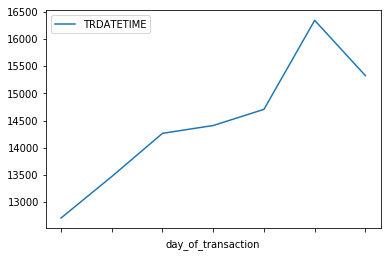

In [30]:
transactions_test.groupby('day_of_transaction').count()[['TRDATETIME']].plot()

In [31]:
# траты в выходные (праздники) 
a = transactions_test.groupby('day_of_transaction').count()[['TRDATETIME']].sort_values(by='day_of_transaction', ascending = False).head(2)
a

,TRDATETIME
day_of_transaction,
6,15325
5,16342


In [32]:
# будни
b = transactions_test.groupby('day_of_transaction').count()[['TRDATETIME']].head()
b

,TRDATETIME
day_of_transaction,
0,12707
1,13470
2,14264
3,14408
4,14705


In [33]:
transactions_train.columns

Index(['PERIOD', 'cl_id', 'MCC', 'channel_type', 'currency', 'TRDATETIME',
       'amount', 'trx_category', 'target_flag', 'target_sum'],
      dtype='object')

In [62]:
redused_train_X = transactions_train[['MCC','channel_type','currency', 'amount','trx_category']]
redused_train_y = transactions_train.target_flag
redused_test_X = transactions_train[['MCC','channel_type','currency', 'amount','trx_category']]
redused_test_y = transactions_train.target_flag

In [35]:
redused_train_X.head()

,MCC,channel_type,currency,amount,trx_category
0,5200,NaN,810,5023.0,POS
1,6011,NaN,810,20000.0,DEPOSIT
2,5921,NaN,810,767.0,POS
3,5411,NaN,810,2031.0,POS
4,6012,NaN,810,36562.0,C2C_OUT


In [63]:
redused_train_X.channel_type[redused_train_X.channel_type.isnull()]='type6'
redused_test_X.channel_type[redused_test_X.channel_type.isnull()]='type6'
#.value_counts(dropna=False)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/li

In [37]:
redused_train_X.channel_type.value_counts()

type1    237675
type2    138470
type5      4958
type4      3089
type3      2726
type6      2374
Name: channel_type, dtype: int64

In [38]:
redused_train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389292 entries, 0 to 490512
Data columns (total 5 columns):
MCC             389292 non-null int64
channel_type    389292 non-null object
currency        389292 non-null int64
amount          389292 non-null float64
trx_category    389292 non-null object
dtypes: float64(1), int64(2), object(2)
memory usage: 17.8+ MB


In [66]:
redused_train_X_dummy = pd.get_dummies(redused_train_X, columns=['MCC', 'channel_type','currency','trx_category'])
redused_test_X_dummy = pd.get_dummies(redused_test_X, columns=['MCC', 'channel_type','currency','trx_category'])
redused_train_X_dummy.head()

,amount,MCC_742,MCC_763,MCC_780,MCC_1520,MCC_1711,MCC_1731,MCC_1750,MCC_1799,MCC_2741,MCC_2842,MCC_3000,MCC_3001,MCC_3005,MCC_3007,MCC_3008,MCC_3010,MCC_3011,MCC_3013,MCC_3015,MCC_3026,MCC_3029,MCC_3032,MCC_3035,MCC_3042,MCC_3047,MCC_3051,MCC_3058,MCC_3064,MCC_3068,MCC_3077,MCC_3098,MCC_3102,MCC_3136,MCC_3181,MCC_3182,MCC_3211,MCC_3217,MCC_3236,MCC_3245,...,currency_498,currency_504,currency_578,currency_604,currency_608,currency_634,currency_643,currency_690,currency_702,currency_704,currency_752,currency_756,currency_764,currency_784,currency_788,currency_810,currency_826,currency_840,currency_901,currency_933,currency_941,currency_944,currency_946,currency_949,currency_975,currency_978,currency_980,currency_981,currency_985,currency_986,trx_category_BACK_TRX,trx_category_C2C_IN,trx_category_C2C_OUT,trx_category_CASH_ADV,trx_category_CAT,trx_category_DEPOSIT,trx_category_POS,trx_category_WD_ATM_OTHER,trx_category_WD_ATM_PARTNER,trx_category_WD_ATM_ROS
0,5023.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,20000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,767.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,2031.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,36562.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [68]:
scaler = StandardScaler()
scaler.fit(redused_train_X_dummy)
columns = redused_train_X_dummy.columns

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


In [69]:
scaler1 = StandardScaler()
scaler1.fit(redused_test_X_dummy)
columns = redused_test_X_dummy.columns

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


In [70]:
redused_train_X_dummy_scaled = scaler.transform(redused_train_X_dummy)
redused_train_X_dummy_scaled = pd.DataFrame(redused_train_X_dummy_scaled, columns=columns)
redused_test_X_dummy_scaled = scaler.transform(redused_test_X_dummy)
redused_test_X_dummy_scaled = pd.DataFrame(redused_test_X_dummy_scaled, columns=columns)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [61]:
redused_train_X_dummy_scaled.head()

,amount,MCC_742,MCC_763,MCC_780,MCC_1520,MCC_1711,MCC_1731,MCC_1750,MCC_1799,MCC_2741,MCC_2842,MCC_3000,MCC_3001,MCC_3005,MCC_3007,MCC_3008,MCC_3010,MCC_3011,MCC_3013,MCC_3015,MCC_3026,MCC_3029,MCC_3032,MCC_3035,MCC_3042,MCC_3047,MCC_3051,MCC_3058,MCC_3064,MCC_3068,MCC_3077,MCC_3098,MCC_3102,MCC_3136,MCC_3181,MCC_3182,MCC_3211,MCC_3217,MCC_3236,MCC_3245,...,currency_498,currency_504,currency_578,currency_604,currency_608,currency_634,currency_643,currency_690,currency_702,currency_704,currency_752,currency_756,currency_764,currency_784,currency_788,currency_810,currency_826,currency_840,currency_901,currency_933,currency_941,currency_944,currency_946,currency_949,currency_975,currency_978,currency_980,currency_981,currency_985,currency_986,trx_category_BACK_TRX,trx_category_C2C_IN,trx_category_C2C_OUT,trx_category_CASH_ADV,trx_category_CAT,trx_category_DEPOSIT,trx_category_POS,trx_category_WD_ATM_OTHER,trx_category_WD_ATM_PARTNER,trx_category_WD_ATM_ROS
0,-0.010433,-0.011558,-0.005779,-0.003205,-0.005779,-0.008014,-0.003584,-0.004808,-0.004808,-0.003205,-0.002267,-0.003205,-0.004533,-0.003205,-0.002776,-0.005779,-0.005997,-0.035825,-0.004808,-0.003205,-0.001603,-0.001603,-0.00424,-0.002776,-0.002776,-0.005316,-0.001603,-0.005997,-0.001603,-0.002267,-0.002776,-0.002267,-0.003584,-0.004533,-0.001603,-0.003205,-0.002267,-0.002267,-0.001603,-0.003205,...,-0.008328,-0.003926,-0.014691,-0.002776,-0.002267,-0.002267,-0.008924,-0.004533,-0.015122,-0.010632,-0.016109,-0.013411,-0.027956,-0.018347,-0.001603,0.163933,-0.022672,-0.063,-0.003584,-0.032191,-0.004533,-0.007518,-0.002776,-0.02791,-0.024629,-0.106907,-0.022214,-0.017994,-0.030169,-0.003205,-0.074661,-0.125675,-0.108057,-0.006207,-0.050595,-0.211981,0.424296,-0.121138,-0.143885,-0.203025
1,0.164780,-0.011558,-0.005779,-0.003205,-0.005779,-0.008014,-0.003584,-0.004808,-0.004808,-0.003205,-0.002267,-0.003205,-0.004533,-0.003205,-0.002776,-0.005779,-0.005997,-0.035825,-0.004808,-0.003205,-0.001603,-0.001603,-0.00424,-0.002776,-0.002776,-0.005316,-0.001603,-0.005997,-0.001603,-0.002267,-0.002776,-0.002267,-0.003584,-0.004533,-0.001603,-0.003205,-0.002267,-0.002267,-0.001603,-0.003205,...,-0.008328,-0.003926,-0.014691,-0.002776,-0.002267,-0.002267,-0.008924,-0.004533,-0.015122,-0.010632,-0.016109,-0.013411,-0.027956,-0.018347,-0.001603,0.163933,-0.022672,-0.063,-0.003584,-0.032191,-0.004533,-0.007518,-0.002776,-0.02791,-0.024629,-0.106907,-0.022214,-0.017994,-0.030169,-0.003205,-0.074661,-0.125675,-0.108057,-0.006207,-0.050595,4.717394,-2.356848,-0.121138,-0.143885,-0.203025
2,-0.060223,-0.011558,-0.005779,-0.003205,-0.005779,-0.008014,-0.003584,-0.004808,-0.004808,-0.003205,-0.002267,-0.003205,-0.004533,-0.003205,-0.002776,-0.005779,-0.005997,-0.035825,-0.004808,-0.003205,-0.001603,-0.001603,-0.00424,-0.002776,-0.002776,-0.005316,-0.001603,-0.005997,-0.001603,-0.002267,-0.002776,-0.002267,-0.003584,-0.004533,-0.001603,-0.003205,-0.002267,-0.002267,-0.001603,-0.003205,...,-0.008328,-0.003926,-0.014691,-0.002776,-0.002267,-0.002267,-0.008924,-0.004533,-0.015122,-0.010632,-0.016109,-0.013411,-0.027956,-0.018347,-0.001603,0.163933,-0.022672,-0.063,-0.003584,-0.032191,-0.004533,-0.007518,-0.002776,-0.02791,-0.024629,-0.106907,-0.022214,-0.017994,-0.030169,-0.003205,-0.074661,-0.125675,-0.108057,-0.006207,-0.050595,-0.211981,0.424296,-0.121138,-0.143885,-0.203025
3,-0.045436,-0.011558,-0.005779,-0.003205,-0.005779,-0.008014,-0.003584,-0.004808,-0.004808,-0.003205,-0.002267,-0.003205,-0.004533,-0.003205,-0.002776,-0.005779,-0.005997,-0.035825,-0.004808,-0.003205,-0.001603,-0.001603,-0.00424,-0.002776,-0.002776,-0.005316,-0.001603,-0.005997,-0.001603,-0.002267,-0.002776,-0.002267,-0.003584,-0.004533,-0.001603,-0.003205,-0.002267,-0.002267,-0.001603,-0.003205,...,-0.008328,-0.003926,-0.014691,-0.002776,-0.002267,-0.002267,-0.008924,-0.004533,-0.015122,-0.010632,-0.016109,-0.013411,-0.027956,-0.018347,-0.001603,0.163933,-0.022672,-0.063,-0.003584,-0.032191,-0.004533,-0.007518,-0.002776,-0.02

In [73]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

In [74]:
clf.fit(redused_train_X_dummy_scaled, redused_train_y)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [75]:
from sklearn.metrics import roc_auc_score

In [76]:
y_val_pred = clf.predict(redused_test_X_dummy_scaled)

In [77]:
roc_auc_score(redused_test_y, y_val_pred)

0.5611725697552623